<a href="https://colab.research.google.com/github/Ami202512/AIML_Project_and_Labs/blob/main/AIML_Module_2_Lab_4_t_SNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 2: Appreciating, Interpreting and Visualizing Data
## Lab 4: t-Distributed Stochastic Neighbor Embedding (t-SNE)

---



This lab will be based upon t-SNE which is a dimensionality reduction algorithm used to visualize high dimensional datasets.

t-SNE stands for t-Distributed Stochastic Neighbor Embedding. It is an unsupervised, non-linear technique primarily used for data exploration and visualizing high-dimensional data. It was developed by Laurens van der Maatens and Geoffrey Hinton in 2008 (Link to the paper: https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)

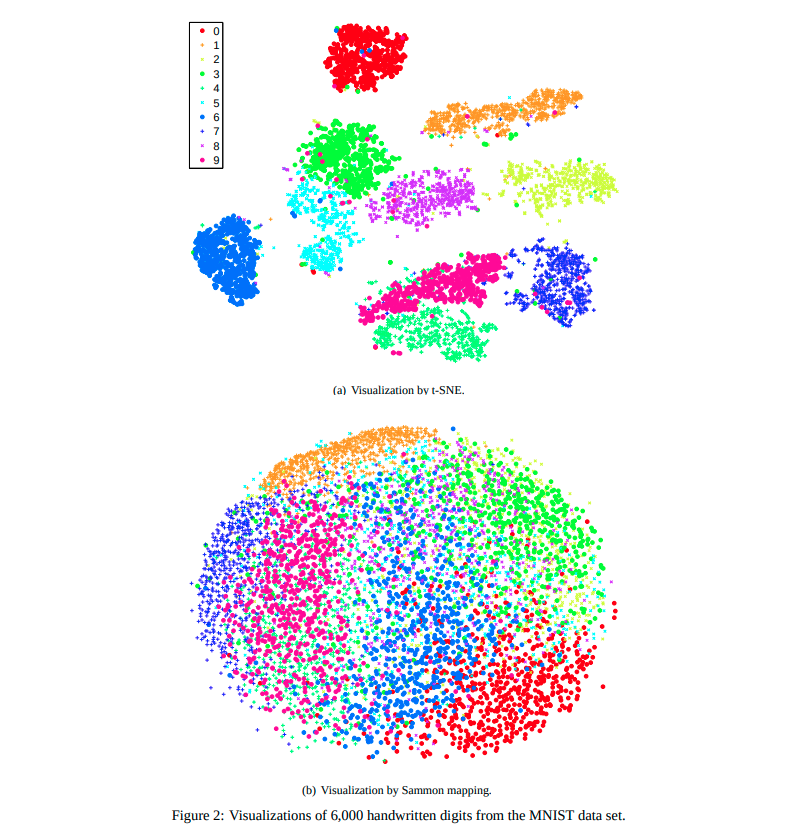

t-SNE has a tuneable parameter, **perplexity** which balances attention between the local and global aspects of your data. It is a guess about the number of close neighbors each point has. The perplexity value has a complex effect on the resulting pictures. The original paper says, “The performance of t-SNE is fairly robust to changes in the perplexity, and typical values are between 5 and 50.” But the story is more nuanced than that. Getting the most from t-SNE may mean analyzing multiple plots with different perplexities.

Also the t-SNE algorithm doesn’t always produce similar output on successive runs as there are additional hyperparameters related to the optimization process.

### HOW DOES T-SNE WORK??

The t-SNE algorithm calculates a similarity measure between pairs of instances in the high dimensional space and in the low dimensional space. It then tries to optimize these two similarity measures using a cost function. Let’s break that down into 3 basic steps.

1. Measure similarities between points in the high dimensional space. Think of a bunch of data points scattered on a 2D space. For each data point (xi) we’ll center a Gaussian distribution over that point. Then we measure the density of all points (xj) under that Gaussian distribution. Then renormalize for all points. This gives us a set of probabilities (Pij) for all points. Those probabilities are proportional to the similarities. All that means is, if data points x1 and x2 have equal values under this gaussian circle then their proportions and similarities are equal and hence you have local similarities in the structure of this high-dimensional space. The Gaussian distribution or circle can be manipulated using what’s called perplexity, which influences the variance of the distribution (circle size) and essentially the number of nearest neighbors.

2. This step is similar to step 1, but instead of using a Gaussian distribution we use a Student t-distribution with one degree of freedom, which is also known as the Cauchy distribution (See fig below). This gives us a second set of probabilities (Qij) in the low dimensional space. As you can see the Student t-distribution has heavier tails than the normal distribution. The heavy tails allow for better modeling of far apart distances.

3. The last step is that we want these set of probabilities from the low-dimensional space (Qij) to reflect those of the high dimensional space (Pij) as best as possible. We want the two map structures to be similar. We measure the difference between the probability distributions of the two-dimensional spaces using Kullback-Liebler divergence (KL). Finally, we use gradient descent to minimize our KL cost function.

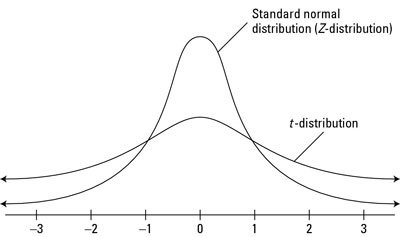

Scikit-learn has an implementation of t-SNE available which provides a wide variety of tuning parameters for t-SNE, and the most notable ones are:

1. n_components (default: 2): Dimension of the embedded space.
2. perplexity (default: 30): The perplexity is related to the number of nearest neighbors that are used in other manifold learning algorithms. Consider selecting a value between 5 and 50.
3. n_iter (default: 1000): Maximum number of iterations for the optimization. Should be at least 250.
4. method (default: ‘barnes_hut’): Barnes-Hut approximation runs in O(NlogN) time. method=’exact’ will run on the slower, but exact, algorithm in O(N^2) time.

In [1]:
# numpy.
import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# Random state.
RS = 20150101

# matplotlib.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# seaborn.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

1797 images each of size 8 x 8 loaded using load_digits()

In [2]:
digits = load_digits()
digits.data.shape

(1797, 64)

Printing some images from the dataset

---



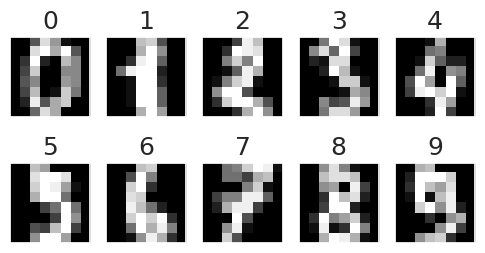

In [3]:
nrows, ncols = 2, 5
plt.figure(figsize=(6,3))
plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(digits.images[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(digits.target[i])

In [4]:
# We first reorder the data points according to the handwritten numbers.
X = np.vstack([digits.data[digits.target==i]
               for i in range(10)])
y = np.hstack([digits.target[digits.target==i]
               for i in range(10)])

## Now using TSNE to fit the dataset with the default values.


1. n_components : 2
2. perplexity : 30
3. n_iter : 1000
4. method : ‘barnes_hut’


---



In [5]:
digits_proj = TSNE(init="pca", random_state=RS).fit_transform(X)

#### Visualizing the data in the projected space

---



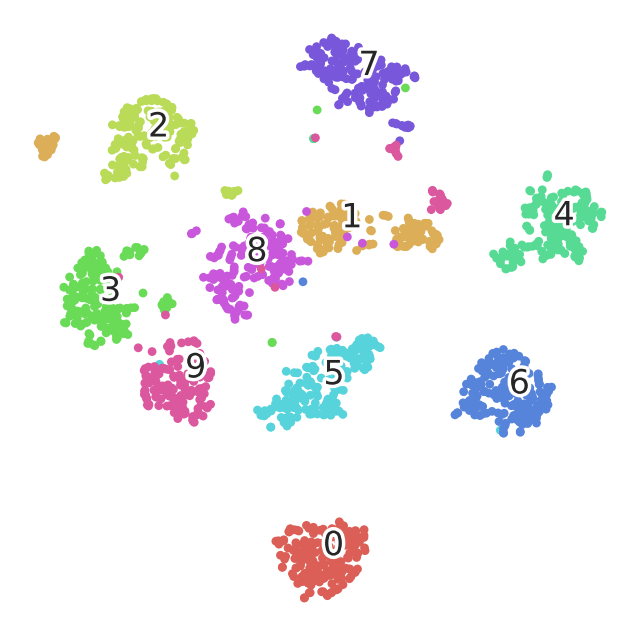

(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 <matplotlib.collections.PathCollection at 0x7d9c1e380a00>)

In [6]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    plt.show()

    return f, ax, sc

scatter(digits_proj, y)

# Tweaking some of the hyperparameters to better understand their role

---

### Changing the PERPLEXITY values


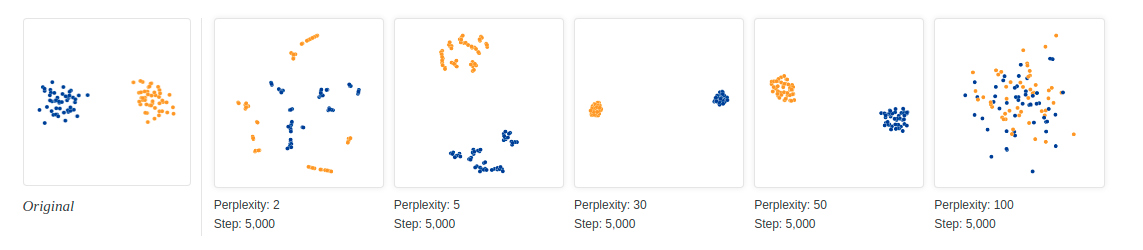

With perplexity values in the range (5 - 50) suggested by van der Maaten & Hinton, the diagrams do show these clusters, although with very different shapes. Outside that range, things get a little weird. With perplexity 2, local variations dominate. The image for perplexity 100, with merged clusters, illustrates a pitfall: for the algorithm to operate properly, the perplexity really should be smaller than the number of points. Implementations can give unexpected behavior otherwise.



---


1. n_components : 2
2. perplexity : **5**
3. n_iter : 1000
4. method : ‘barnes_hut’


---

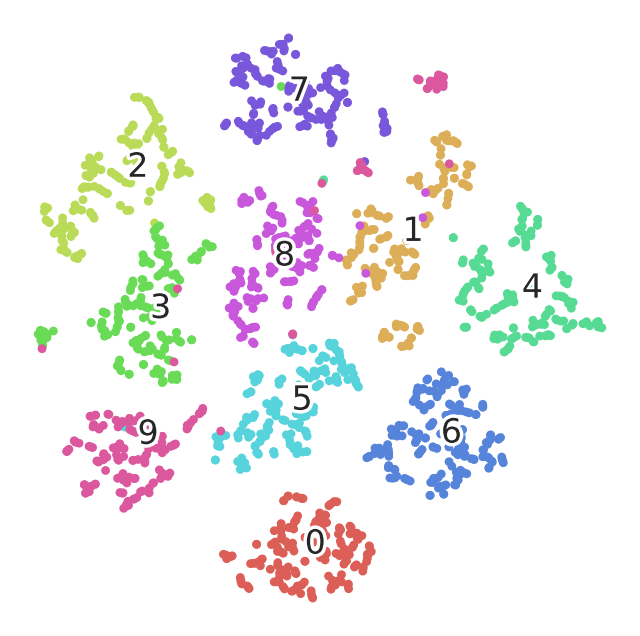

(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 <matplotlib.collections.PathCollection at 0x7d9c1eca64d0>)

In [7]:
digits_proj = TSNE(init="pca", random_state=RS, perplexity=5).fit_transform(X)

scatter(digits_proj, y)

We can see that there are local clusters within the same number group as well. This is happening as the perplexity being at 5, allows the local neighbourhood to dominate. Let us now see what happens if we increase the perplexity to 100, thereby increasing global impact.





---


1. n_components : 2
2. perplexity : **100**
3. n_iter : 1000
4. method : ‘barnes_hut’


---

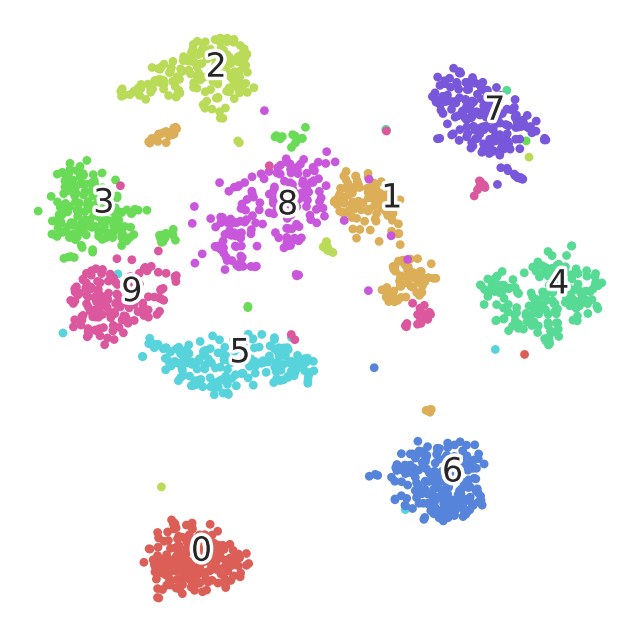

(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 <matplotlib.collections.PathCollection at 0x7d9c1ef4d420>)

In [8]:
digits_proj = TSNE(init="pca", random_state=RS, perplexity=100).fit_transform(X)

scatter(digits_proj, y)

The general structure of the plot remained similar to the one with perplexity = 30 (default), but on careful observation you can observe many data points not being part of the group they are supposed to be in. This is because of the large number of points considered for the neighbourhood (as perplexity value = 100 is higher), thereby allowing 2 data points from different groups to end up closer.



---

### Changing the NUMBER OF ITERATIONS

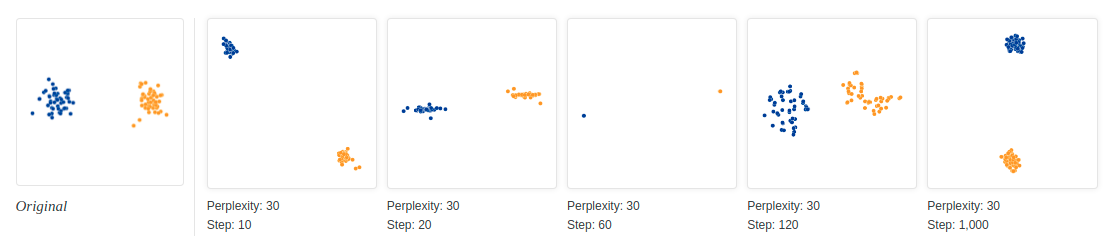

The images above show five different runs at perplexity 30. The first four were stopped before stability. After 10, 20, 60, and 120 steps you can see layouts with seeming 1-dimensional and even pointlike images of the clusters. If you see a t-SNE plot with strange “pinched” shapes, chances are the process was stopped too early. Unfortunately, there’s no fixed number of steps that yields a stable result. Different data sets can require different numbers of iterations to converge.

The most important thing is to iterate until reaching a stable configuration.





---


1. n_components : 2
2. perplexity : 30
3. n_iter : **250**
4. method : ‘barnes_hut’


---

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


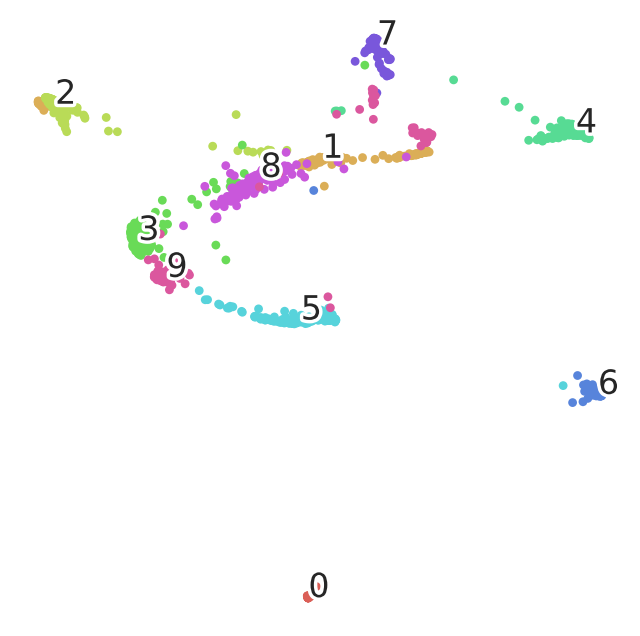

(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 <matplotlib.collections.PathCollection at 0x7d9c1d092bf0>)

In [9]:
digits_proj = TSNE(init="pca", random_state=RS, n_iter=250).fit_transform(X)

scatter(digits_proj, y)

As can be seen from the figure above, stopping the optimization earlier (in 250 iterations) resulted in a suboptimal clustering of the groups.

Let us now see how the results are affected if t-SNE is run for larger number of iterations


---


1. n_components : 2
2. perplexity : 30
3. n_iter : **5000**
4. method : ‘barnes_hut’


---

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


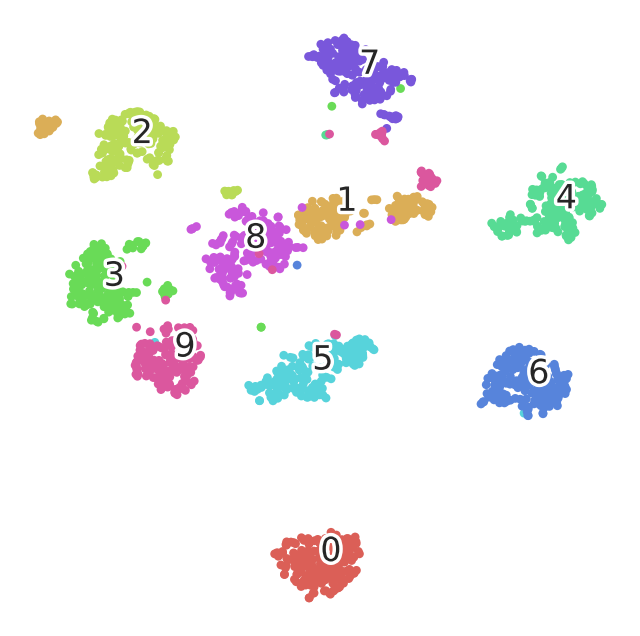

(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 <matplotlib.collections.PathCollection at 0x7d9c1e385450>)

In [10]:
digits_proj = TSNE(init="pca", random_state=RS, n_iter=5000).fit_transform(X)

scatter(digits_proj, y)

Running for larger number of iterations more or less resulted in the same plot as the optimization had nearly converged till the default 1000 iterations. However the density of the clusters has increased.

---

### Changing the method to EXACT

The barnes-hut method takes O(NlogN) time, whereas the exact method takes O(N^2) time. Notice the increase in the execution time while running the cell below.


---

1. n_components : 2
2. perplexity : 30
3. n_iter : 1000
4. method : **‘exact’**


---

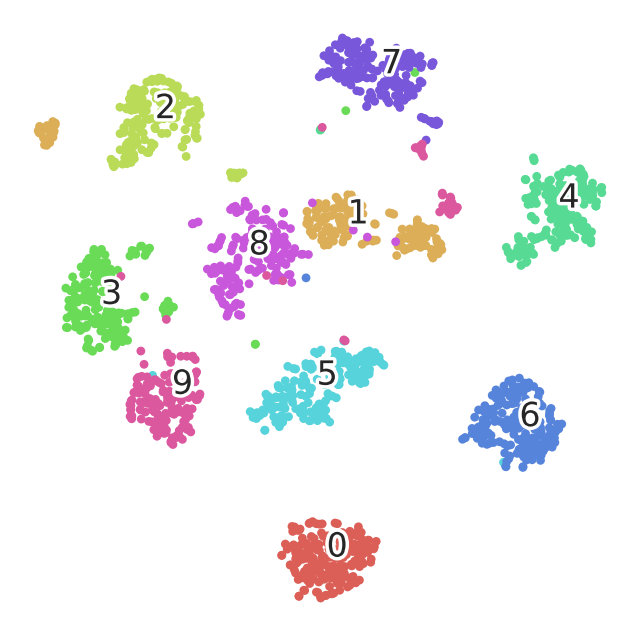

(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 <matplotlib.collections.PathCollection at 0x7d9c1e414d90>)

In [11]:
digits_proj = TSNE(init="pca", random_state=RS, method='exact').fit_transform(X)

scatter(digits_proj, y)

## EXERCISE

---



Try out different perplexity and iteration values to better appreciate the concepts taught.

You can modify the code in the cell below to check the resultant plots.

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


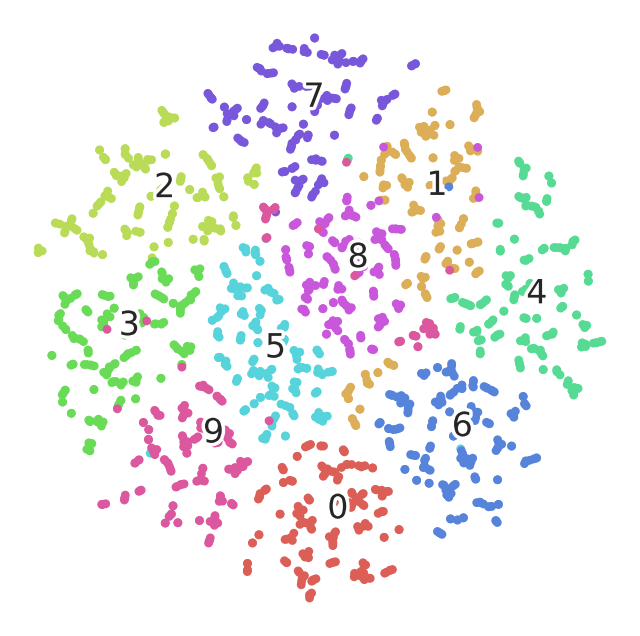

(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 <matplotlib.collections.PathCollection at 0x7d9c170313c0>)

In [12]:
###############################################################
###### MODIFY THE VALUES FOR THE HYPERPARAMETERS BELOW ########

perplexity_value = 2
number_iterations = 1000
method = "barnes_hut"

###############################################################

digits_proj = TSNE(init="pca", random_state=RS, n_iter=number_iterations, perplexity=perplexity_value, method=method).fit_transform(X)
scatter(digits_proj, y)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


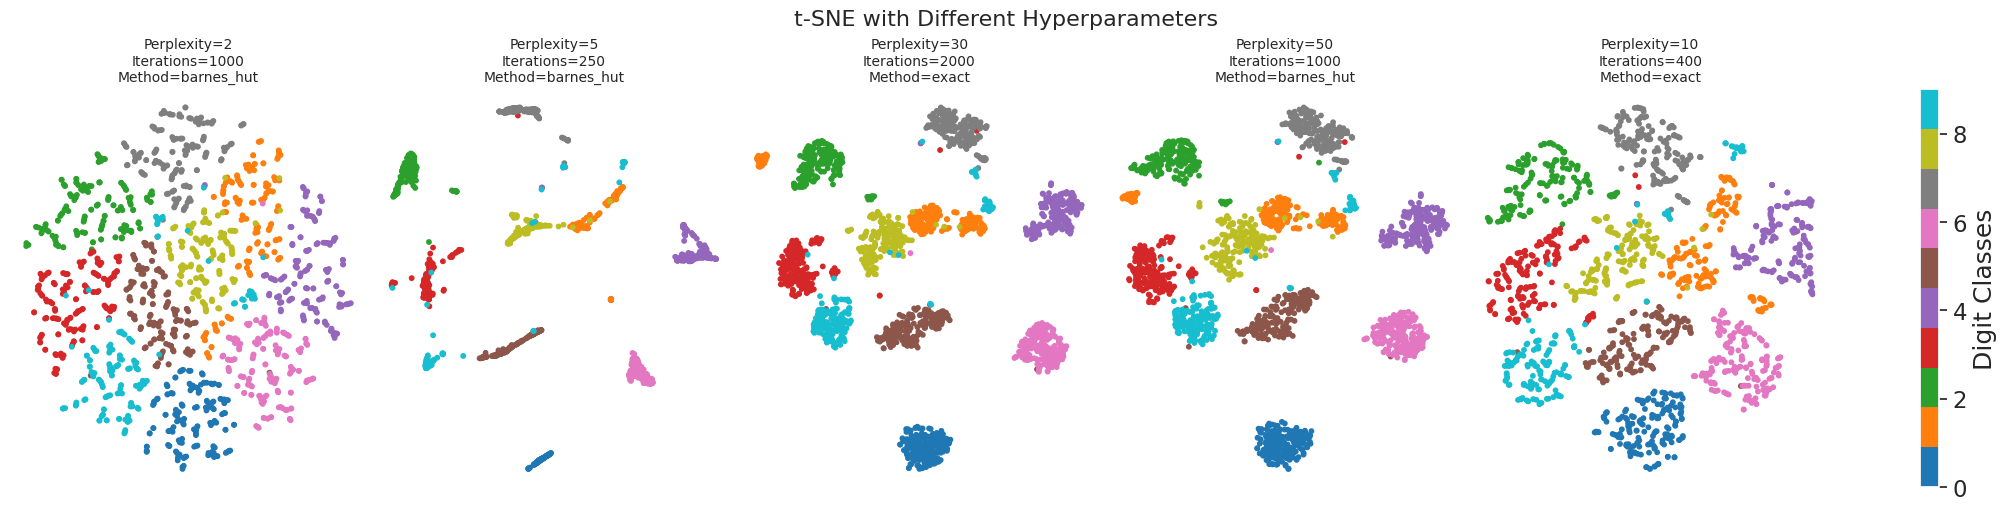

In [16]:
cases = [
    {"perplexity": 2, "n_iter": 1000, "method": "barnes_hut"},
    {"perplexity": 5, "n_iter": 250, "method": "barnes_hut"},
    {"perplexity": 30, "n_iter": 2000, "method": "exact"},
    {"perplexity": 50, "n_iter": 1000, "method": "barnes_hut"},
    {"perplexity": 10, "n_iter": 400, "method": "exact"},
]

fig, axes = plt.subplots(1, len(cases), figsize=(20, 5), constrained_layout=True)
fig.suptitle("t-SNE with Different Hyperparameters", fontsize=16)

for ax, params in zip(axes, cases):
    perplexity_value = params["perplexity"]
    number_iterations = params["n_iter"]
    method = params["method"]

    digits_proj = TSNE(
        init="pca",
        random_state=RS,
        n_iter=number_iterations,
        perplexity=perplexity_value,
        method=method
    ).fit_transform(X)

    scatter = ax.scatter(
        digits_proj[:, 0],
        digits_proj[:, 1],
        c=y,
        cmap="tab10",
        s=10
    )
    ax.set_title(
        f"Perplexity={perplexity_value}\nIterations={number_iterations}\nMethod={method}",
        fontsize=10
    )
    ax.axis("off")

plt.colorbar(scatter, ax=axes, location='right', label='Digit Classes')
plt.show()



---

## Exercise:

1. Now that you understand t-SNE a bit better, can you point out some differences between PCA and t-SNE. What are the advantages/disadvantages of one over the other?


>##### Pointers:

> a. Which of the two algorithms is linear and which one is non-linear?    
b. How does the non-linearity in one of these two algorithms help in capturing certain data sets?    
c. PCA is known to keep points which were further apart in the higher dimension, far apart in the lower dimension as well. Does t-SNE do the same? Or does it try to preserve local neighbourhood?    
d. Can you comment on which one of the two is computationally more expensive?



| Feature                                 | PCA                                      | t-SNE                                     |
|-----------------------------------------|------------------------------------------|-------------------------------------------|
| **Type of Algorithm**                   | Linear                                   | Non-linear                                |
| **Data Capturing Ability**              | Captures global structure and variance. | Captures local structure and neighborhood relationships. |
| **Distance Preservation**               | Preserves global distances, ensuring that points far apart in higher dimensions remain far apart in lower dimensions. | Focuses on preserving local neighborhoods; may distort global distances. |
| **Computational Expense**               | Computationally less expensive; scales better with large datasets. | Computationally more expensive due to iterative optimization; scales poorly with large datasets. |


2. How does the computational complexity and runtime of t-SNE scale with dataset size and dimensionality?

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Completed t-SNE for N=100, D=10 in 0.28 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Completed t-SNE for N=500, D=10 in 2.55 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Completed t-SNE for N=1000, D=10 in 2.56 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Completed t-SNE for N=5000, D=10 in 16.02 seconds
Completed t-SNE for N=100, D=50 in 0.15 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Completed t-SNE for N=500, D=50 in 1.54 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Completed t-SNE for N=1000, D=50 in 4.52 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Completed t-SNE for N=5000, D=50 in 26.19 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Completed t-SNE for N=100, D=100 in 0.27 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Completed t-SNE for N=500, D=100 in 3.48 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Completed t-SNE for N=1000, D=100 in 5.08 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Completed t-SNE for N=5000, D=100 in 18.22 seconds


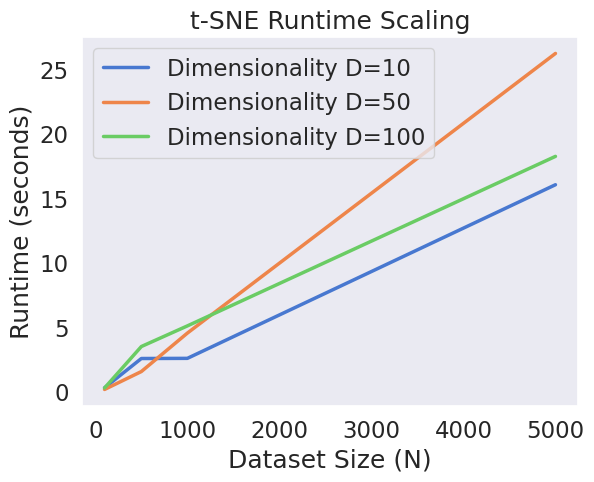

In [18]:
import time

def measure_tsne_runtime(data_sizes, dims, perplexity_value, number_iterations, method):
    runtimes = {}
    for D in dims:
        runtimes[D] = []
        for N in data_sizes:
            X = np.random.rand(N, D)

            tsne = TSNE(
                n_components=2,
                random_state=42,
                perplexity=perplexity_value,
                n_iter=number_iterations,
                method=method
            )

            start_time = time.time()
            tsne.fit_transform(X)
            runtime = time.time() - start_time

            runtimes[D].append(runtime)
            print(f"Completed t-SNE for N={N}, D={D} in {runtime:.2f} seconds")
    return runtimes

data_sizes = [100, 500, 1000, 5000]
dims = [10, 50, 100]

perplexity_value = 30
number_iterations = 300
method = "barnes_hut"

runtimes = measure_tsne_runtime(data_sizes, dims, perplexity_value, number_iterations, method)

for D, runtime in runtimes.items():
    plt.plot(data_sizes, runtime, label=f"Dimensionality D={D}")

plt.title("t-SNE Runtime Scaling")
plt.xlabel("Dataset Size (N)")
plt.ylabel("Runtime (seconds)")
plt.legend()
plt.grid()
plt.show()

**Obsevartions from the Plot**

1. **Scaling with Dataset Size:**

*   Runtime increases **almost linearly** with the number of samples, consistent with the (O(N \log N)) complexity of Barnes-Hut t-SNE.

2. **Dimensionality:**

*   Increasing dimensionality leads to a slower runtime due to the linear dependency of the similarity calculations.

3. While t-SNE can handle large datasets efficiently, runtime is still significantly affected by both dataset size and dimensionality. Preprocessing (e.g., PCA to reduce dimensionality) can help mitigate this.





3. What are some limitations or potential pitfalls to be aware of when using t-SNE? (tell atleast 3)

1. **Loss of Global Structure:**
* t-SNE focuses on preserving local structure, often distorting global relationships between clusters.
* Use other dimensionality reduction methods like PCA before applying t-SNE for better global structure preservation.

2. **Hyperparameter Sensitivity:**
* Results are highly sensitive to hyperparameters like perplexity and learning rate, leading to varying embeddings.
* Experiment with different hyperparameters or use grid search to find the optimal settings.

3. **Computational Complexity:**
*  t-SNE is computationally expensive for large datasets and high-dimensional data.
* Use approximations like Barnes-Hut to speed up computations for larger datasets.




---
 ## Some interesting references:

 1. https://blog.paperspace.com/dimension-reduction-with-t-sne/
 2. https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1
 3. https://distill.pub/2016/misread-tsne/



---


